In [1]:
import torch
import torchvision
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F  # All functions that don't have any parameters
from torch.utils.data import (
    DataLoader,
)  # Gives easier dataset managment and creates mini batches
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt
torch.manual_seed(0)#You can use torch.manual_seed function to seed the script globally

# Dataset preprocessing for batch predictions

In [66]:
'''real data path'''
realData_path = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color"

# model_name = '3th epoch_layer4&fc_Testingloss=0.16397 and acc=94.26%.pth'
model_name = '163th epoch_resnet_aug_layer4&fc_Testingloss=0.14409 and acc=94.4%.pth'

# smalldatatest
# realData_path = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\5_smallDatasetCAM"
# realData_posPath = r"C:\Users\SmartLab\Desktop\NUS\3d_Recon\6_Dataset\_Data for model\5_smallDatasetCAMPos"


In [3]:
# Custom dataset

from skimage import io
import os
from torch.utils.data import Dataset

class Realdata(Dataset): #inherit from Dataset
    def __init__(self, root_dir, transform=None):
        self.fileCount = len([f for f in os.listdir(root_dir) if not f.startswith('.')])
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return self.fileCount

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, [f for f in os.listdir(self.root_dir) if not f.startswith('.')][index])
        image = io.imread(img_path)

        if self.transform:
            image = self.transform(image)
        return (image)
    
    
# load and transform real dataset to be consistent with ImageNet for prediction
realData_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224, 224)),  # Resizes
        transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])
realData = Realdata(root_dir=realData_path, transform=realData_transform)
print(f'total number of real data to identify surface defects {len(realData)}')

total number of real data to identify surface defects 2637


# Real data batch prediction

In [35]:
# ReLoad model is necessary otherwise does not work， not sure why
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.resnet50(pretrained=False) # we do not specify pretrained=True, i.e. do not load default weights

num_classes = 3

# # modify only the last fully connected layer to be consistent with previous modifications
# model.fc = nn.Sequential(
#     nn.Linear(2048, 1000), nn.ReLU(), 
#     nn.Linear(1000, 500), nn.ReLU(), 
#     nn.Linear(500, 200), nn.ReLU(), 
#     nn.Linear(200, num_classes)
# )

# second/third experiement with simple
model.fc = nn.Sequential(
nn.Linear(2048, num_classes))

model.to(device)

# load trained model
model.load_state_dict(torch.load(model_name))
model.eval()


# Load data for batch prediction
data_loader = DataLoader(dataset=realData, batch_size=1, shuffle=False)


# batch prediction
def batch_prediction(loader, model):
    
    model.eval()
    num_correct = 0
    num_samples = 0
    prediction_lst = []
    confidence_lst = []
    
    with torch.no_grad():
        for batch_idx, (img) in enumerate(loader):
            img = img.to(device=device)
            out = model(img)
    
            # get how confident the model think it is the allocated label
            percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
            percentage = round(max(percentage.tolist()),1)

            # prediction result
            _, predicted = torch.max(out, 1)
            predicted = predicted.item()
            
            confidence_lst.append(percentage)
            prediction_lst.append(predicted)

    print(f'{len(prediction_lst)} predictions have been processed')
    return prediction_lst, confidence_lst
    
pred_lst, confid_lst = batch_prediction(data_loader, model)
# check the prediction results
print(pred_lst)
print(confid_lst)

2637 predictions have been processed
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [37]:
print(len(pred_lst),len(confid_lst))

2637 2637


In [70]:
import os
from PIL import Image
import pandas as pd
conf_lvl = 0

realData_fileName = []
# 这个取filename的过程和之前custom data取数据来做预测用的是同一个函数[f for f in...],所以这个filenmae肯定是和predication对应的
# 对应关系是没有错的，即使这里的filename的顺序和电脑不一样，但是他们是对应的就行
for i, filename in enumerate([f for f in os.listdir(realData_path) if not f.startswith('.')]):#get rid of ds.sore
    realData_fileName.append(filename)
    
# print(realData_fileName)

# filter data to get the positive filenames with specified confidence level
realData_df = pd.DataFrame( {'realData_fileName':realData_fileName,'Prediction':pred_lst, 'Confidence': confid_lst})
realData_pos = realData_df[realData_df['Prediction'].isin([1,2])].reset_index(drop=True)
realData_pos = realData_pos[realData_pos['Confidence']>conf_lvl].reset_index(drop=True)

# get file path for all postive filenames 
pic_pos_path = []
for i in range(len(realData_pos)):
    pic_pos_path.append(os.path.join(realData_path,str(realData_pos['realData_fileName'][i])))

# display all rows
pd.set_option('display.max_rows', None)    
# check all prediction results with corresponding filenames
# display(realData_df)
# check positive data only with corresponding filenames
display(realData_pos)
# result description
print(f'there are totoal {len(pic_pos_path)} images out of {len(realData)} are tested positive with confidence > {conf_lvl}%')

,realData_fileName,Prediction,Confidence
0,00000.jpg,2,100.0
1,00001.jpg,2,100.0
2,00002.jpg,2,100.0
3,00003.jpg,2,100.0
4,00004.jpg,2,99.9
5,00005.jpg,2,99.8
6,00006.jpg,2,99.9
7,00007.jpg,2,100.0
8,00008.jpg,2,100.0
9,00009.jpg,2,99.8


there are totoal 2302 images out of 2637 are tested positive with confidence > 0%


# Grad-CAM

In [73]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchvision.models import resnet50
# TorchCAM: class activation explorer：https://github.com/frgfm/torch-cam
from torchcam.methods import GradCAM
from torchcam.utils import overlay_mask
import torch
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
import numpy as np
from matplotlib import cm
import cv2
from torchvision import transforms
target_layer = 'layer4'
require_transparency = True # 模型需不需要透明，透明的主要用来展示的，不透明的是用来找中心点然后计算global coordinates的

def overlay_mask_modified(img: Image.Image, mask: Image.Image, colormap: str = "jet", alpha: float = 0.7) -> Image.Image:

    if not isinstance(img, Image.Image) or not isinstance(mask, Image.Image):
        raise TypeError("img and mask arguments need to be PIL.Image")

    if not isinstance(alpha, float) or alpha < 0 or alpha > 1:
        raise ValueError("alpha argument is expected to be of type float between 0 and 1")

    cmap = cm.get_cmap(colormap)
    # Resize mask and apply colormap
    overlay = mask.resize(img.size, resample=Image.BICUBIC)
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))

    return overlayed_img

In [74]:
# produce CAM pics and save it
for i in range(len(pic_pos_path)):
    # where to start CAM process if you dont want to CAM for all images
    if i >= 0:
    
        '''ReLoad model is necessary otherwise CAM does not work'''
        # Set device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = torchvision.models.resnet50(pretrained=False) # we do not specify pretrained=True, i.e. do not load default weights
        num_classes = 3
        
        # second experiement simple fc
        model.fc = nn.Sequential(
        nn.Linear(2048, num_classes))

        model.to(device)
        # load trained model
        model.load_state_dict(torch.load(model_name))
        model.eval()


        '''CAM processing and saving image'''
        # load the positive pics file path for CAM
        img_checkPath= pic_pos_path[i]
        # CAM
        cam_extractor = GradCAM(model, target_layer=target_layer) # realod the model again if it does not work, potentially because of the accuracy check process above
        # Get your input
        img = read_image(img_checkPath)
        # Use same data transformation like previous prediction
        # model on gpu, so data should on gpu as well
        input_tensor = realData_transform(img).to(device)

        # Preprocess your data and feed it to the model
        # unsqueeze because of the batch dimension is missing, meaning we did not use DataLoader to load data
        out = model(input_tensor.unsqueeze(0))

        # get how confident the model think it is positive
        percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
        percentage = round(max(percentage.tolist()),1)

        # prediction result
        _, predicted = torch.max(out, 1)
        predicted = predicted.item()

        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

        # # Visualize the raw CAM
        # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()
        
        if require_transparency: # 如果需要透明度来展示
            realData_posPath = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color_CAM_transparent"
            alpha = 0.7
            cmap = matplotlib.colors.ListedColormap(['w','y'], N=2)
            img = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode="F"), colormap=cmap, alpha=alpha)
        else: # 如果不需要透明度来做模型找中点，然后确定global coordinates
            # Resize the CAM and overlay it, cmap is designed for transparent background
            realData_posPath = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color_CAM_solid"
            alpha = 0.0
            cmap = matplotlib.colors.ListedColormap(['white', 'yellow'])
            img = to_pil_image(img)
            act_pattern = overlay_mask_modified(img, to_pil_image(activation_map[0].squeeze(0), mode="F"), colormap=cmap, alpha=alpha)
            act_pattern = act_pattern.convert("RGBA")
            datas = act_pattern.getdata()
            newData = []
            for item in datas:
                if item[0] == 255 and item[1] == 255 and item[2] == 255:
                    newData.append((255, 255, 255, 0))
                else:
                    newData.append(item)
            act_pattern.putdata(newData)
            transp_act = act_pattern
            img.paste(transp_act, (0, 0), transp_act.convert("RGBA"))
    
        # name with more info
        # result.save(os.path.join(realData_posPath, 'pred='+str(predicted)+'_'+str(percentage)+'%Confidence_'+str(realData_pos['realData_fileName'][i][:-4]+'_cam_'+'.jpg')))
        
        # same as original file name
        img.save(os.path.join(realData_posPath, realData_pos['realData_fileName'][i]))

        # # Display it
        # plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

print('Job Done!!!!!')

Job Done!!!!!


# miscellaneous code for copy selected cam images to yellow folder

In [86]:
from os import listdir
from os.path import isfile, join
from shutil import copyfile
import shutil

selected = r'C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color_CAM_selected'
src_dir = r'C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color_CAM_transparent'
dst_dir = r"C:\Users\SmartLab\Desktop\traditional recon and CAM\3d_Recon\rosbag\HDB1\color_CAM_selected_yellow"
fileList = [f for f in listdir(selected) if isfile(join(selected, f))]
# print(len(fileList))

for item in fileList:
    src = os.path.join(src_dir, item)
    dst = os.path.join(dest_dir, item)
    shutil.copy(src, dst)

# 调整torchcam让背景变透明,调节detection的颜色等调试代码

In [135]:
# to_pil_image(activation_map).save(r'C:\Users\SmartLab\Desktop\NUS\test_activation.jpg')
# to_pil_image(img).save(r'C:\Users\SmartLab\Desktop\NUS\test_img.jpg')

In [4]:
from PIL import Image

def overlay_mask_modified(img: Image.Image, mask: Image.Image, colormap: str = "jet", alpha: float = 0.7) -> Image.Image:

    if not isinstance(img, Image.Image) or not isinstance(mask, Image.Image):
        raise TypeError("img and mask arguments need to be PIL.Image")

    if not isinstance(alpha, float) or alpha < 0 or alpha > 1:
        raise ValueError("alpha argument is expected to be of type float between 0 and 1")

    cmap = cm.get_cmap(colormap)
    # Resize mask and apply colormap
    overlay = mask.resize(img.size, resample=Image.BICUBIC)
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))

    return overlayed_img

In [63]:
import matplotlib
import numpy as np
from matplotlib import cm
import cv2

'''提取activation pattern，非activation的地方默认为白色'''
alpha = 0.0 # 必须float，0的话提取activation pattern，背景不要了，为白色
activation = transforms.ToTensor()(Image.open(r"C:\Users\SmartLab\Desktop\traditional recon and CAM\test_activation.jpg"))
img = transforms.ToTensor()(Image.open(r"C:\Users\SmartLab\Desktop\traditional recon and CAM\test_img.jpg"))
# 背景全白，activation的地方变红或者其他指定颜色，提取activation pattern
cmap = matplotlib.colors.ListedColormap(['white', 'red'])
act_pattern = overlay_mask_modified(to_pil_image(img), to_pil_image(activation.squeeze(0), mode="F"), colormap=cmap, alpha=alpha)


'''把pattern的白色区域变成透明的，准备后面的overlay'''
# https://stackoverflow.com/questions/765736/how-to-use-pil-to-make-all-white-pixels-transparent
act_pattern = act_pattern.convert("RGBA")
# act_pattern.save(r"C:\Users\SmartLab\Desktop\act_pattern.png")
# plt.imshow(act_pattern); plt.axis('off'); plt.tight_layout(); plt.show()
datas = act_pattern.getdata()
newData = []
for item in datas:
    # 把白色(255,255,255)的地方，也就是背景通通变成transparency
    # color picker来找这个颜色的rgb：https://imagecolorpicker.com/en
    if item[0] == 255 and item[1] == 255 and item[2] == 255:
        newData.append((255, 255, 255, 0))
    else:
        newData.append(item)
act_pattern.putdata(newData)
transp_act = act_pattern
# transp_act.save(r"C:\Users\SmartLab\Desktop\trans.png")
'''把透明背景的activation pattern加在需要的背景上，透明的地方就变成了背景
然后非透明，也就是activation的地方就变成activation的颜色来highlight defects'''
background = Image.open(r"C:\Users\SmartLab\Desktop\traditional recon and CAM\test_img.jpg")
overlay = transp_act
# 合并背景和activation得到最后的背景不动，activation地方全红的最后图片
background.paste(overlay, (0, 0), overlay.convert("RGBA"))
background.save(r"C:\Users\SmartLab\Desktop\final.png","PNG")

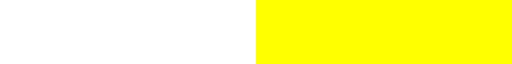

In [59]:
matplotlib.colors.ListedColormap(['white','yellow'])

# 提取出的cam图片测试不同的alpha对recon的颜色影响，从原图取图换alpha做cam

In [78]:
# 提取filename
ReadyCAM = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\rosbag\CAM_recon\2_color_CAM'
# filename和这个用来取原图
originaImg = r'C:\Users\SmartLab\Desktop\NUS\3d_Recon\rosbag\connectingBridge_38s\color'
for i, filename in enumerate([f for f in os.listdir(ReadyCAM) if not f.startswith('.')]):#get rid of ds.sore
    '''ReLoad model is necessary otherwise CAM does not work'''
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = torchvision.models.resnet50(pretrained=False) # we do not specify pretrained=True, i.e. do not load default weights
    num_classes = 3
    
#     # modify only the last fully connected layer to be consistent with previous modifications
#     model.fc = nn.Sequential(
#         nn.Linear(2048, 1000), nn.ReLU(), 
#         nn.Linear(1000, 500), nn.ReLU(), 
#         nn.Linear(500, 200), nn.ReLU(), 
#         nn.Linear(200, num_classes)
#     )
    
    # second experiement simple fc
    model.fc = nn.Sequential(
    nn.Linear(2048, num_classes))
    
    model.to(device)
    # load trained model
    model.load_state_dict(torch.load(model_name))
    model.eval()
    
    
    '''CAM processing and saving image'''
    # load the positive pics file path for CAM
    img_checkPath= os.path.join(originaImg, filename)
    # CAM
    cam_extractor = GradCAM(model, target_layer=target_layer) # realod the model again if it does not work, potentially because of the accuracy check process above
    # Get your input
    img = read_image(img_checkPath)
    # Use same data transformation like previous prediction
    # model on gpu, so data should on gpu as well
    input_tensor = realData_transform(img).to(device)

    # Preprocess your data and feed it to the model
    # unsqueeze because of the batch dimension is missing, meaning we did not use DataLoader to load data
    out = model(input_tensor.unsqueeze(0))
    
    # get how confident the model think it is positive
    percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
    percentage = round(max(percentage.tolist()),1)
    
    # prediction result
    _, predicted = torch.max(out, 1)
    predicted = predicted.item()
    
    # Retrieve the CAM by passing the class index and the model output
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    # # Visualize the raw CAM
    # plt.imshow(activation_map[0].squeeze(0).numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

    # Resize the CAM and overlay it, alpha for transparency control
#     cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['w','c','r'], gamma=2.2)
    cmap = matplotlib.colors.ListedColormap(['w','c'], N=2)
    result = overlay_mask_modifiedWT(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode="F"), colormap=cmap)
    result.save(os.path.join(ReadyCAM, filename))

    
print('Job Done!!!!!')

Job Done!!!!!


In [35]:
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
_, predicted = torch.max(out, 1)
print(out)
print(percentage)
print(max(percentage))
print(predicted.item())
print(round(max(percentage.tolist()),1))

tensor([[-10.0558,  -1.2118,   6.6924]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([5.3233e-06, 3.6903e-02, 9.9963e+01], device='cuda:0',
       grad_fn=<MulBackward0>)
tensor(99.9631, device='cuda:0', grad_fn=<UnbindBackward0>)
2
100.0


In [9]:
result.size

(300, 300)